# Workflow for building temperature Profiles

## Slightly Modified Connor's Code for Importing Video and Tracking:

In [16]:
##Import Libraries##
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
from pandas import DataFrame, Series  # for convenience
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pims
import trackpy as tp
import cv2
import os
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy import constants
import statistics
from matplotlib.widgets import Slider
import random

In [17]:
default_rc = dict(mpl.rcParams) #safe the default plotting settings into a variable

In [18]:
##Optionally, tweak styles.##
mpl.rc('figure',  figsize=(10, 10*(1236/1376))) #400/375
mpl.rc('image', cmap='gray')

In [19]:
scl = 1236/1376 #!!!INPUT

In [20]:
##Optionally, tweak styles.##
mpl.rc('figure',  figsize=(10, 10*(1236/1376))) #400/375
mpl.rc('image', cmap='gray')

##______________________________________________________________________________________________________________________________________________##

###Convert Video to Image Sequence and save to directory###

#File path of video that needs converted
folderPath = r'g:\My Drive\workAppState\prj_shocks\expData\data20230501temperatureProfileTest'

#Filepath for directory to save image sequence
videoName = r'\8sccm'
#Video Type
vidType = '.avi'
#Image Type
imgType = '.png'

##CODE DOES NOT NEED ALTERED FOR VIDEO/IMAGE-SEQUENCE CONVERTER PAST THIS POINT
#Read the video from specified path
    
cam = cv2.VideoCapture(folderPath + r'\inputs' + videoName + vidType)
  
try:
      
    # creating a folder named 
    direcPath = folderPath + r'\outputs\ImageSequences' + videoName
    if not os.path.exists(direcPath):
        os.makedirs(direcPath)
  
# if not created then raise error
except OSError:
    print ('Error: Creating directory of data')
  
# frame
currentframe = 0
  
while(True):
      
    # reading from frame
    ret,frame = cam.read()
  
    if ret:
        # if video is still left continue creating images
        name = direcPath + r'\frame' + str(currentframe) + imgType
        print ('Creating...' + name)
  
        # writing the extracted images
        cv2.imwrite(name, frame)
  
        # increasing counter so that it will
        # show how many frames are created
        currentframe += 1
    else:
        break
  
# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

##______________________________________________________________________________________________________________________________________________##

###Create Directory for Plots###

if not os.path.exists(folderPath + r'\outputs\Plots' + videoName):
    os.makedirs(folderPath + r'\outputs\Plots' + videoName)
    

##______________________________________________________________________________________________________________________________________________##

###Import image sequence and convert to grayscale###

#Define function that converts to grayscale
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel


#Creates an array for grayscale frames
frames = []



Creating...g:\My Drive\workAppState\prj_shocks\expData\data20230501temperatureProfileTest\outputs\ImageSequences\8sccm\frame0.png
Creating...g:\My Drive\workAppState\prj_shocks\expData\data20230501temperatureProfileTest\outputs\ImageSequences\8sccm\frame1.png
Creating...g:\My Drive\workAppState\prj_shocks\expData\data20230501temperatureProfileTest\outputs\ImageSequences\8sccm\frame2.png
Creating...g:\My Drive\workAppState\prj_shocks\expData\data20230501temperatureProfileTest\outputs\ImageSequences\8sccm\frame3.png
Creating...g:\My Drive\workAppState\prj_shocks\expData\data20230501temperatureProfileTest\outputs\ImageSequences\8sccm\frame4.png
Creating...g:\My Drive\workAppState\prj_shocks\expData\data20230501temperatureProfileTest\outputs\ImageSequences\8sccm\frame5.png
Creating...g:\My Drive\workAppState\prj_shocks\expData\data20230501temperatureProfileTest\outputs\ImageSequences\8sccm\frame6.png
Creating...g:\My Drive\workAppState\prj_shocks\expData\data20230501temperatureProfileTest\

 
View of current image before cropping provided in plots tab
 


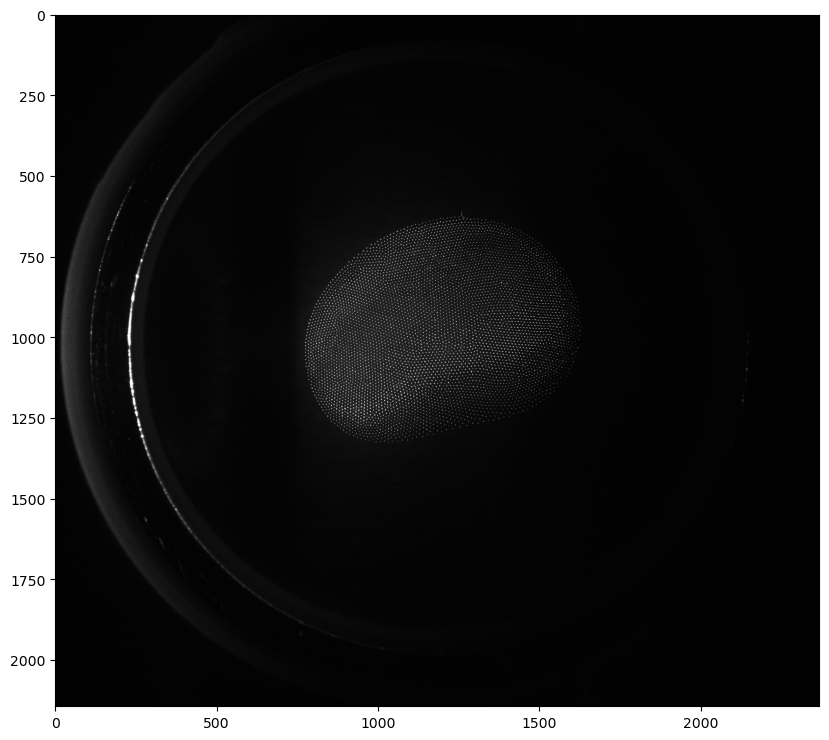

Recommended starting scale is x=525:900 y=375:775
(Press enter when prompted for input to use recommended scale)


In [22]:
#Access first image in directory as test image
testim = gray(cv2.imread(direcPath + r'\frame' + str(0) + imgType))
print(" ")
print("View of current image before cropping provided in plots tab")
print(" ")
plt.imshow(testim)
plt.show()
#Pauses and closes plot for auto grapic mode (not needed for inline mode)
#plt.pause(pause time)
plt.pause(5)
plt.close()
print("Recommended starting scale is x=525:900 y=375:775")
print("(Press enter when prompted for input to use recommended scale)")

Input min x pixel coordinate: 1000
Input max x pixel coordinate: 1500
Input min y pixel coordinate: 800


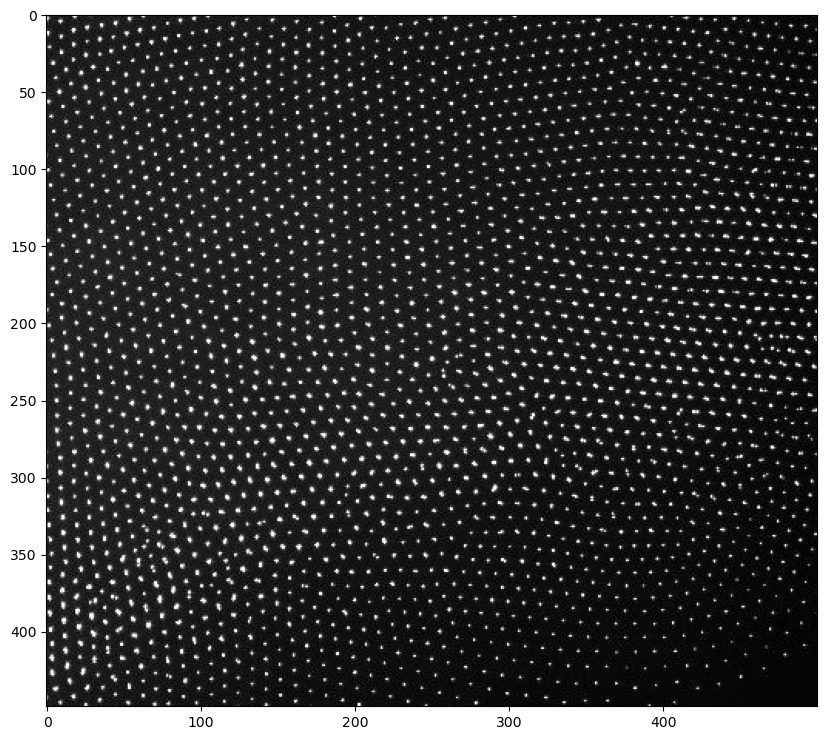

Would you like to reset scale? (yes or no): no


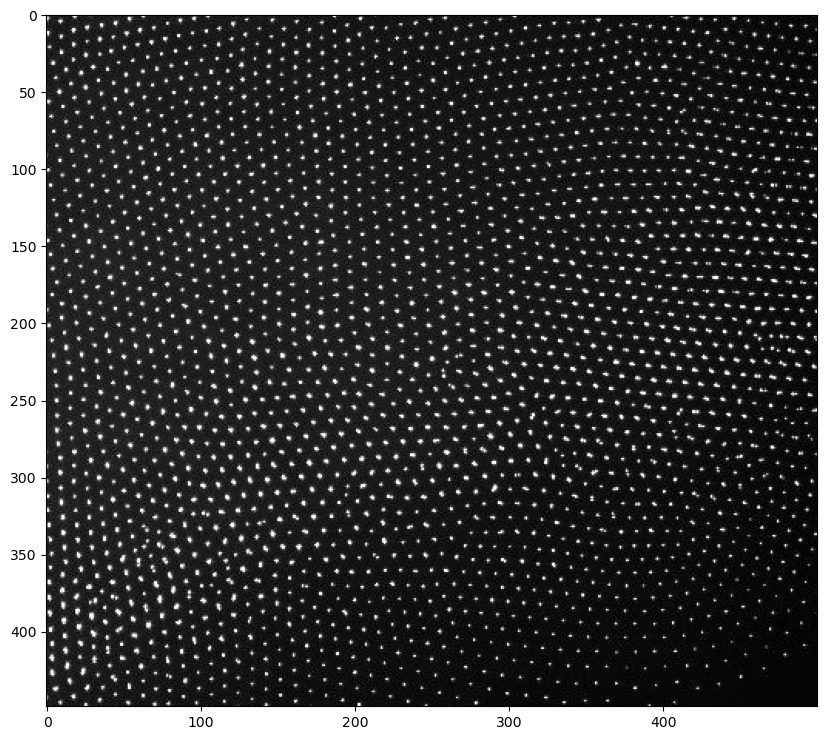

In [23]:
#Loop to test cropping scale and then apply to entire directory
while True:
    #Input for cropping scale
    xFrames1 = int(input("Input min x pixel coordinate: ") or "550")
    xFrames2 = int(input("Input max x pixel coordinate: ") or "925")
    yFrames1 = int(input("Input min y pixel coordinate: ") or "450")
    yFrames2 = int(((xFrames2-xFrames1)*(scl))+yFrames1)
    #Crops test images
    exFrame = testim[yFrames1:yFrames2, xFrames1:xFrames2]
    #Shows cropped image
    plt.imshow(exFrame)
    plt.show()
    #Pauses and closes plot for auto grapic mode (not needed for inline mode)
    plt.pause(5)
    plt.close()
    #Request to proceed
    answer = input("Would you like to reset scale? (yes or no): ")
    #If/Else statement to restart or break loop depending on input
    if answer=="yes":
        #Restarts loop for new crop scale
        continue 
    else:
        #Loop to apply cropping to all images in directory
        for i in range(currentframe):
            #Access image in directory
            im = gray(cv2.imread(direcPath + r'\frame' + str(i) + imgType))
            #Crops image and saves to array
            frames.append(im[yFrames1:yFrames2, xFrames1:xFrames2])
        
        #ends the loop
        break

#Show first frame in cropped image array
plt.imshow(frames[0])

 
Recommended starting values for tp.locate(): PixSize=3, minmass=15, seperation=3, threshhold=0, invert=False
(Press enter when prompted for input to use recommended values)
Frame number: 10
Feature size in pixels (odd#>2): 
Minmass: 
Seperation: 
Threshold: 
Invert: 
Head of DataFrame: 
          y           x       mass      size       ecc     signal  raw_mass  \
1  2.400000    1.814286  21.595385  0.765320  0.341463   8.946659     510.0   
2  2.105000   18.800000  30.850549  0.771362  1.327731  12.494473     535.0   
3  2.000000   63.004854  31.776066  0.815505  1.503650  10.643440     654.0   
4  2.168367  105.933673  30.233538  0.820652  0.984848   9.872176     454.0   
5  2.219409  186.101266  36.557901  0.831855  0.810976  11.260451     423.0   

         ep  
1 -0.037530  
2 -0.039009  
3 -0.048011  
4 -0.034594  
5 -0.033157  


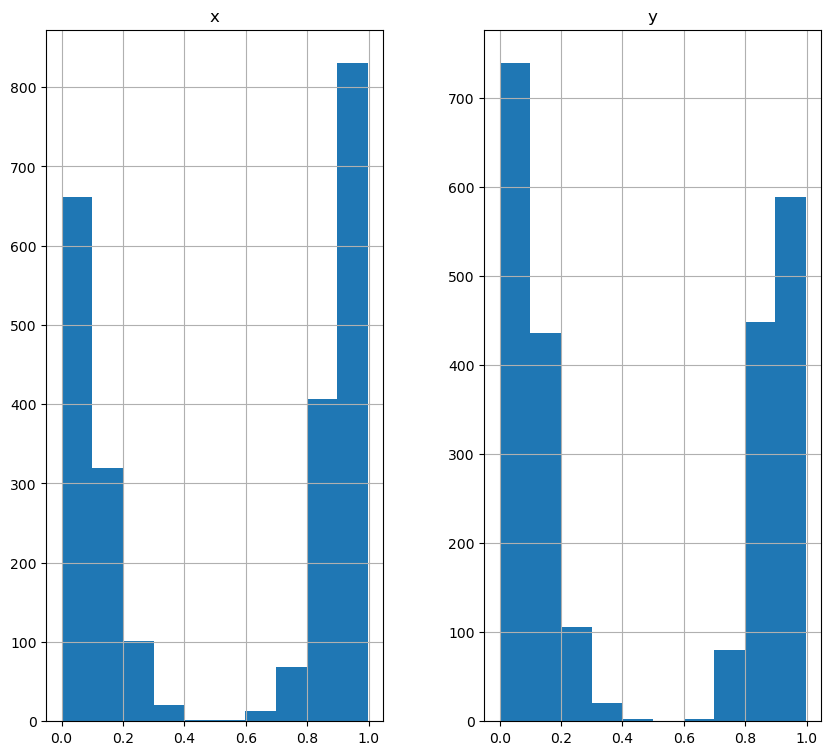

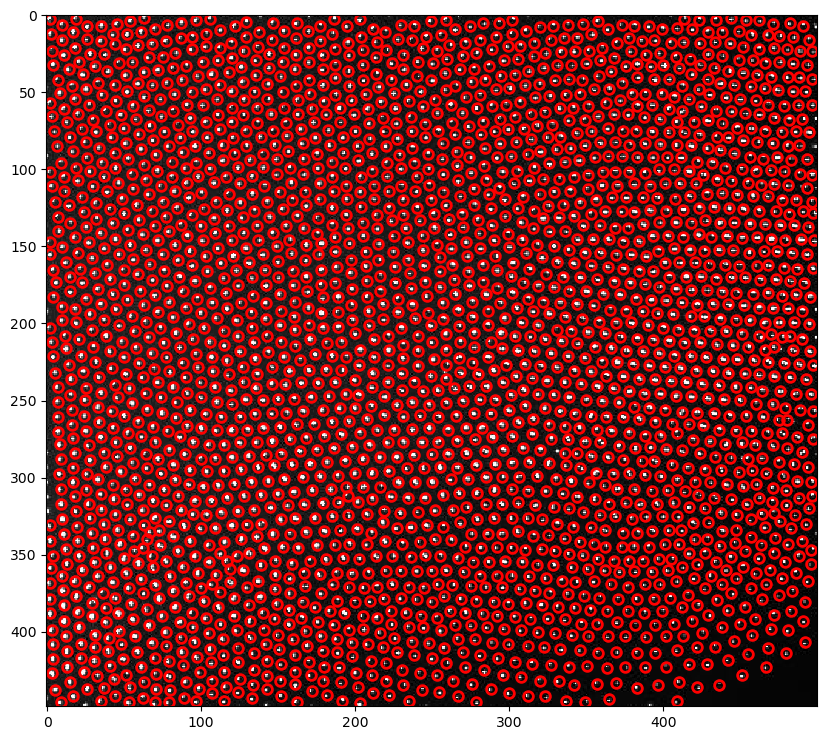

FileNotFoundError: [Errno 2] No such file or directory: 'g:\\My Drive\\workAppState\\prj_shocks\\expData\\data20230501temperatureProfileTest\\Plots\\8sccm\\Annotation.png'

In [25]:
##______________________________________________________________________________________________________________________________________________##

###Locate Features for single frame###
    
print(" ")
print("Recommended starting values for tp.locate(): PixSize=3, minmass=15, seperation=3, threshhold=0, invert=False")
print("(Press enter when prompted for input to use recommended values)")
#Loop to test locate feature variables and then apply to entire directory
while True:
    ##Locating pixels
    #Asking for input from user for locate feature, if no input use recommended settings
    fra = int(input("Frame number: ") or "0")
    pix = int(input("Feature size in pixels (odd#>2): ") or "3")
    minM = int(input("Minmass: ") or "10")
    sep = int(input("Seperation: ") or "5")
    thresh = int(input("Threshold: ") or "0")
    inv = input("Invert: ") or "False"
    #Locates particles using defined settings
    #tp.locate(frame,estimated feature size in pixels, minmass removes features below value, invert frame color)
    fSing = tp.locate(frames[fra], pix, minmass=minM, separation=sep, threshold=thresh, invert=inv)
    #prints data head
    print("Head of DataFrame: ")
    print(fSing.head(5))
    
    ##Check the subpixel accuracy
    #This checks that decimal part of the x and or position are evenly distributed
    #If mask size is too small, histogram shows dip in middle
    tp.subpx_bias(fSing)
    plt.show()
    #Pauses and closes plot for auto grapic mode (not needed for inline mode)
    plt.pause(1)
    plt.close()
    ##Create plot and circles features
    fig = plt.figure()
    tp.annotate(fSing, frames[fra],plot_style={'markersize':7}) 
    plt.show()
    plt.pause(30)
    plt.close()
    #Save fig (only works in inline mode due to trackpy)
    fig.savefig(folderPath + r'\Plots' + videoName + r'\Annotation' + imgType)

    ##Request to proceed
    answer2 = input("Would you like to change values? (yes or no): ") or "yes"
    if answer2 == "yes":
        #Restarts loop for new values
        continue 
    else:
        #ends the loop
        break

In [27]:
##______________________________________________________________________________________________________________________________________________##

###Link features into Particle Trajectories###

#Batch of frames
fTraj = tp.batch(frames[:], pix, minmass=minM, separation=sep, threshold=thresh, invert=inv)
#Convert and save data to CSV
fTraj.to_csv(folderPath + r'\outputs\csvData' + videoName + r'.csv')

##Track particle from frame to frame
# Turn off progress reports for best performance
tp.quiet()
#tp.link(batch frames, max distance in pixels particle can travel betwen frame, 
#        number of frames memory maintains ID for disappeared particles)
t = tp.link(fTraj,3,memory=1)
#Head of new DataSet
t.head()

Frame 42: 2419 features


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,1.953271,18.004673,29.234147,0.733064,1.686957,13.524208,673.0,-0.050376,0,0
1612,286.937788,226.877880,59.287944,0.845154,0.451613,16.939413,206.0,-0.025948,0,1
1613,287.136161,363.136161,61.200458,0.826460,0.202614,19.398360,255.0,-0.027339,0,2
1614,286.966997,431.848185,41.392274,0.791873,1.489474,15.436723,767.0,-0.062154,0,3
1615,288.195531,57.055866,48.905723,0.815355,0.361345,16.392980,460.0,-0.035243,0,4


In [28]:
#function get_velocities(df, step) calculates velocites of particles
# with a given step step.
def get_velocities(df, step):
#initialize empy arrays to store data:
    arr_particle = np.array([])
    arr_x = np.array([])
    arr_y = np.array([])
    arr_vx = np.array([])
    arr_vy = np.array([])
    arr_frame = np.array([])
    # get an array containing all frame numbers in the input dataframe:
    frames_listing = np.unique(np.array(df['frame']))
    #cycle throught all those frames:
    for iFrame in range(step, len(frames_listing)):
        #get current frame:
        cur_frame = frames_listing[iFrame]
        #select a dataframe containing data ONLY for that frame:
        df_front_frame = df[(df['frame'] == cur_frame)]
        #print(iFrame)
        #cycle throught all particles in the frame and find their velocities as
        # position of the particle in that frame minus position of the same particles
        # step frames ago:
        for i in range(0, len(df_front_frame)):
            #take i-th particle in a frame
            cur_p = df_front_frame['particle'].iloc[i]
            cur_x = df_front_frame['x'].iloc[i]
            cur_y = df_front_frame['y'].iloc[i]
            #find a row with the same particle in a frame step frames ago:
            prev_frame_cur_row = df[((df['frame'] == cur_frame - step) & (df['particle'] == cur_p))]
            #if that particle excisted back then, we will get exactly ONE row:
            if (len(prev_frame_cur_row) == 1):
                #if this row exists, we can take position of that particle in that, previous, frame:
                prev_x = prev_frame_cur_row['x'].iloc[0]
                prev_y = prev_frame_cur_row['y'].iloc[0]
                # so we can calculate velocities:
                cur_vx = cur_x - prev_x
                cur_vy = cur_y - prev_y
                cur_particle = df_front_frame['particle'].iloc[i]
                #and append all parameters of that particle to our data arrays
                arr_vx = np.append(arr_vx, cur_vx)
                arr_vy = np.append(arr_vy, cur_vy)
                arr_particle = np.append(arr_particle, cur_particle)
                arr_x = np.append(arr_x, cur_x)
                arr_y = np.append(arr_y, cur_y)
                arr_frame = np.append(arr_frame, cur_frame)
    #save output as a dataframe containing all the info we need:
    data = {'frame':arr_frame, 'particle':arr_particle, 'x': arr_x, 'y': arr_y, 'vx': arr_vx, 'vy':arr_vy}
    ret_df = pd.DataFrame(data)
                
    return ret_df

## Getting the Temperature Profiles

#### constants:

In [61]:
step = 10 # number of frames between the frames for calculating velocities
dust_mass = 4.0 / 3.0 * np.pi * (5.0E-6)**3 * 1510.0 #mass of the dust particles
N_points = 15 # number of points in the temperature profile
rate_for_vel = 33.0 / step # frequency for calculating particle speeds
mm_per_px = 1.0/40.6 # camera resolution
N_bins = 14 #number of bins in the hystograms

#### first, get velocities. May take some time:

In [62]:
vel_csv_path = folderPath + r'\outputs\csvData\velocities' + videoName
if not os.path.exists(vel_csv_path):
    os.makedirs(vel_csv_path)
    df_vel = get_velocities(t, step)
    df_vel.to_csv(vel_csv_path + r'_velocities' + r'.csv')    
else:
    df_vel = pd.read_csv(vel_csv_path + r'_velocities' + r'.csv')
df_vel.head()
    

,Unnamed: 0,frame,particle,x,y,vx,vy
0,0,10.0,6.0,204.934263,288.005976,0.784551,0.011734
1,1,10.0,8.0,463.907591,287.052805,0.813935,-1.019702
2,2,10.0,18.0,8.886435,288.022082,-0.115929,0.927519
3,3,10.0,5.0,71.918981,287.930556,1.946100,-0.418597
4,4,10.0,27.0,99.812721,287.848057,0.864501,1.715370


## Getting the Temperature Profiles. FWHM Method

### Plotting a Sample Histogram and Making sure our FWHM Method Works

#### subtracting global cloud drift:

In [63]:
meanVx = np.mean(df_vel['vx'])
meanVy = np.mean(df_vel['vy'])
arr_vx_noDrift = np.array(df_vel['vx']) - meanVx
arr_vy_noDrift = np.array(df_vel['vy']) - meanVy

In [64]:
#calculating histogram
counts_x, bins_x = np.histogram(arr_vx_noDrift, bins = N_bins)
arr_bins_x_centers = 0.5 * (bins_x[1:] + bins_x[:-1]) # array of the bin centers
arr_vx_freqs = counts_x / len(arr_vx_noDrift) # histogram frequencies

<BarContainer object of 14 artists>

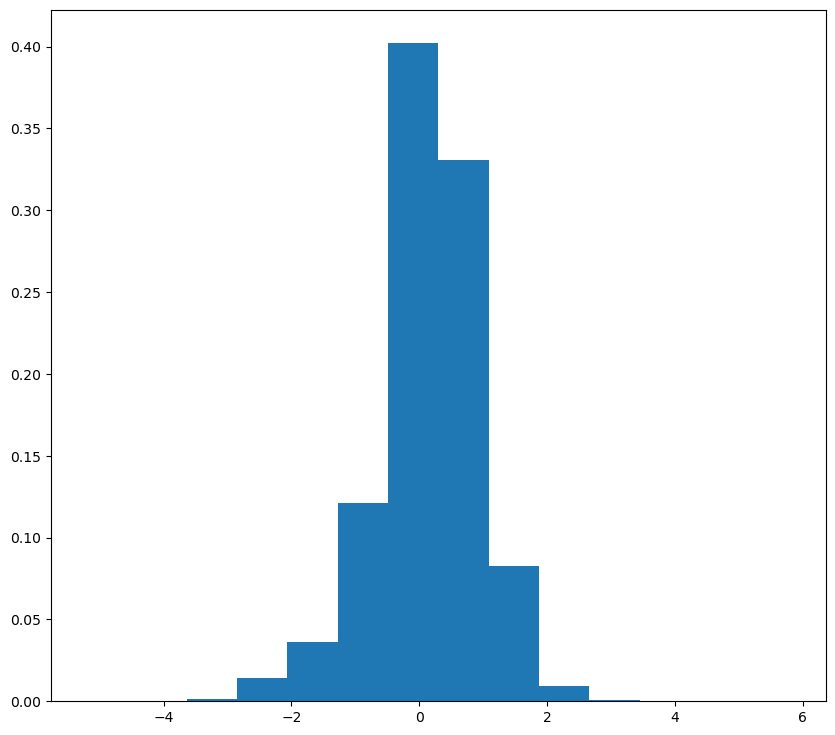

In [65]:
#plotting the histogram
fig_hist_x, ax_hist_x = plt.subplots()
ax_hist_x.bar(arr_bins_x_centers, arr_vx_freqs, width = (arr_bins_x_centers[1] - arr_bins_x_centers[0]))

#### Since the datapoints are sparse, do a cubic splines interpolation:

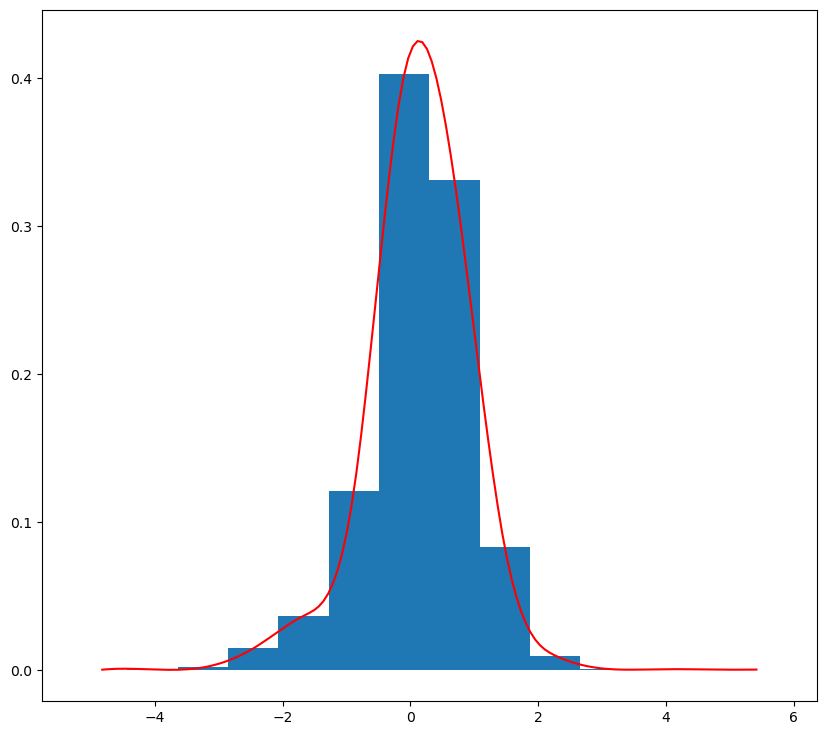

In [66]:
# ten times more dense bins:
arr_bins_dense = np.linspace(np.min(arr_bins_x_centers), np.max(arr_bins_x_centers), num = N_bins * 10)
#interpolating function made of cubic splines:
fx = interp1d(arr_bins_x_centers, arr_vx_freqs, kind = 'cubic')
#interpolate the data:
arr_f_x_interp = fx(arr_bins_dense)
#plot
ax_hist_x.plot(arr_bins_dense, arr_f_x_interp, color = 'red')
fig_hist_x

#### FWHM method:

In [67]:
f_vx_halfmax = np.max(arr_f_x_interp) / 2.0 #calculate the halfmaximum of the interpolated data
#find all x-values corresponding to y-valies laying ABOVE the halfmaximum
arr_vx_above_halfmax = arr_bins_dense[(arr_f_x_interp > f_vx_halfmax)]
#minimum of the x-values will be the left boundary
left_bound_vx = np.min(arr_vx_above_halfmax)
# maximum is the right boundary
right_bound_vx = np.max(arr_vx_above_halfmax)
#FWHM is rgith boundary minus left boundary
FWHM_vx = right_bound_vx - left_bound_vx
FWHM_vx


1.6200487152232501

In [68]:
#quick check, for Gaussian distribution, FWHM should coincide with
sigma_vx = np.std(df_vel['vx'])
sigma_vx * 2 * np.sqrt(2 * np.log(2))

1.996194744323773

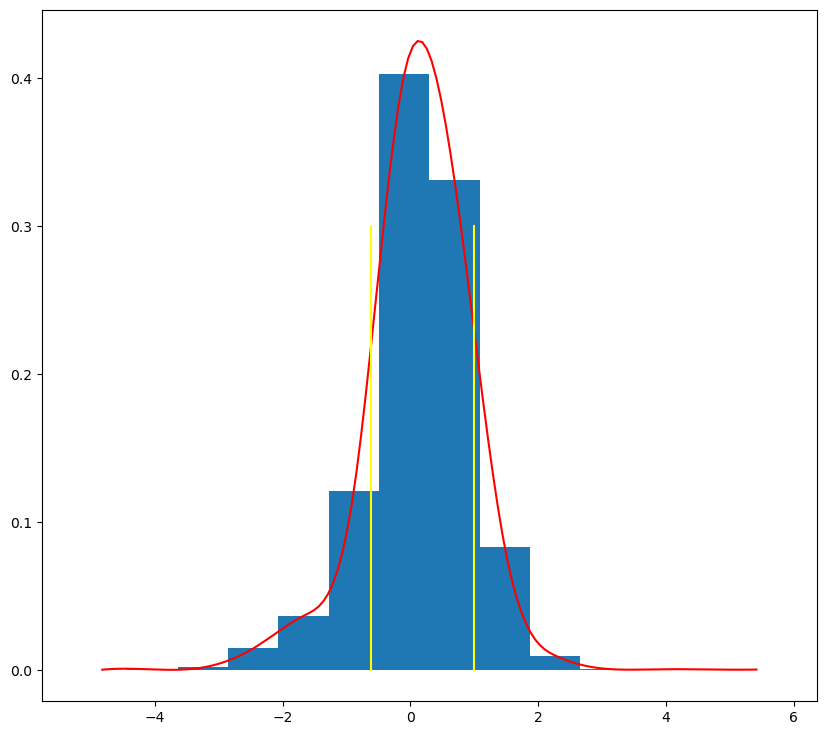

In [69]:
#check if we calculated FWHM correctly by plotting right and left boundary ontop of the previous plot
ax_hist_x.plot(np.zeros(50) + left_bound_vx, np.linspace(0, 0.3, num = 50), color = 'yellow')
ax_hist_x.plot(np.zeros(50) + right_bound_vx, np.linspace(0, 0.3, num = 50), color = 'yellow')
fig_hist_x

In [70]:
def get_FWHM(arr_1dvel, N_bins):
    FWHM = False
    mean_v =  np.mean(arr_1dvel)
    arr_1dvel_noDrift = arr_1dvel - mean_v
    counts, bins = np.histogram(arr_1dvel_noDrift, bins = N_bins)
    arr_bins_centers = 0.5 * (bins[1:] + bins[:-1])
    arr_freqs = counts / len(arr_1dvel_noDrift)
    arr_bins_dense = np.linspace(np.min(arr_bins_centers), np.max(arr_bins_centers), num = N_bins * 100)
    f = interp1d(arr_bins_centers, arr_freqs, kind = 'cubic')
    arr_f_interp = f(arr_bins_dense)
    f_halfmax = np.max(arr_f_interp) / 2.0
    arr_bins_above_halfmax = arr_bins_dense[(arr_f_interp > f_halfmax)]
    left_bound = np.min(arr_bins_above_halfmax)
    right_bound = np.max(arr_bins_above_halfmax)
    FWHM = right_bound - left_bound    
    return FWHM

In [71]:
def get_temper_eV(FWHM, rate_betw_pos, mm_per_pix, part_mass):
    sigma = FWHM / 2.0 / np.sqrt(2.0 * np.log(2.0))
    
    sigma_SI = sigma * mm_per_pix / 1000.0 * rate_betw_pos
    
    temper_eV = part_mass * sigma_SI**2 / constants.elementary_charge 
    
    return temper_eV

In [72]:
def get_temper_profile_FWHM(df_vel, coord_axis, vel_component, N_points):
    left_x = np.min(df_vel[coord_axis])
    right_x = np.max(df_vel[coord_axis])
    x_grid = np.linspace(left_x, right_x, num = N_points)
    delta_x = x_grid[1] - x_grid[0]
    x_grid = x_grid + delta_x/2
    x_grid = x_grid[:-1]
    arr_temper = np.array([])
    for el_x in x_grid:
        sub_df = df_vel[(df_vel[coord_axis] > el_x - delta_x / 2) & (df_vel[coord_axis] < el_x + delta_x / 2)]
        cur_fwhm = get_FWHM(np.array(sub_df[vel_component]), N_bins)
        cur_temper = get_temper_eV(cur_fwhm, rate_for_vel, mm_per_px, dust_mass)
        arr_temper = np.append(arr_temper, cur_temper)
    return x_grid, arr_temper  
    

In [73]:
x_grid, arr_temper_x = get_temper_profile_FWHM(df_vel, 'x', 'vx',  N_points)
x_grid, arr_temper_y = get_temper_profile_FWHM(df_vel, 'x', 'vy', N_points)
df_temper = pd.DataFrame({'x_px':x_grid, 'temper_x_eV':arr_temper_x, 'temper_y_eV':arr_temper_y})
df_temper.head()
temper_csv_path = folderPath + r'\outputs\csvData\temperatures' 
if not os.path.exists(temper_csv_path):
    os.makedirs(temper_csv_path)
    
df_temper.to_csv(temper_csv_path + videoName + r'_temps_FWHM' + r'.csv')

df_temper.head()

,x_px,temper_x_eV,temper_y_eV
0,18.683738,0.001351,0.015755
1,54.187906,0.003215,0.029567
2,89.692073,0.002396,0.012462
3,125.196241,0.014050,0.016585
4,160.700409,0.001205,0.012293


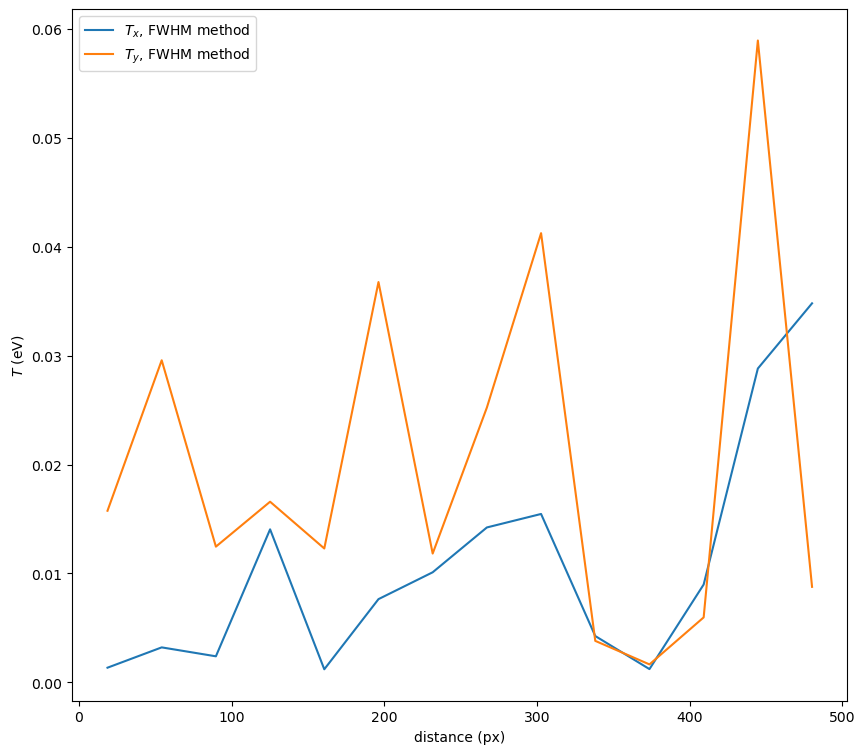

In [74]:
fig, ax = plt.subplots()
ax.plot(x_grid, arr_temper_x, label = '$T_x$, FWHM method')
ax.plot(x_grid, arr_temper_y, label = '$T_y$, FWHM method')
#ax.set_xlim(0, 400)
#ax.set_ylim(0,130)
ax.set_xlabel('distance (px)')
ax.set_ylabel('$T$ (eV)')
ax.legend()


## Getting the Temperature Profiles. Direct Standard Deviation Method

In [ ]:
def get_temper_profile_direct(df_vel, coord_axis, vel_component, N_points):
    left_x = np.min(df_vel[coord_axis])
    right_x = np.max(df_vel[coord_axis])
    x_grid = np.linspace(left_x, right_x, num = N_points)
    delta_x = x_grid[1] - x_grid[0]
    x_grid = x_grid + delta_x/2
    x_grid = x_grid[:-1]
    arr_temper_frosigmas = np.array([])
    for el_x in x_grid:
        sub_df = df_vel[(df_vel[coord_axis] > el_x - delta_x / 2) & (df_vel[coord_axis] < el_x + delta_x / 2)]
        sub_df.head()
        cur_sigma = np.std(np.array(sub_df[vel_component]))
        sigma_SI = cur_sigma * mm_per_px / 1000.0 * rate_for_vel
        temper_eV = dust_mass * sigma_SI**2 / constants.elementary_charge
        arr_temper_frosigmas = np.append(arr_temper_frosigmas, temper_eV)
    return x_grid, arr_temper_frosigmas


In [76]:
x_grid, arr_temper_x_dir = get_temper_profile_direct(df_vel, 'x', 'vx',  N_points)
x_grid, arr_temper_y_dir = get_temper_profile_direct(df_vel, 'x', 'vy',  N_points)
df_temper = pd.DataFrame({'x_px':x_grid, 'T_x_eV':arr_temper_x_dir, 'T_y_eV':arr_temper_y_dir})
df_temper.head()
temper_csv_path = folderPath + r'\outputs\csvData\temperatures' 
if not os.path.exists(temper_csv_path):
    os.makedirs(temper_csv_path)
    
df_temper.to_csv(temper_csv_path + videoName + r'_temps_direct' + r'.csv')

df_temper.head()

,x_px,T_x_eV,T_y_eV
0,18.683738,0.013394,0.015462
1,54.187906,0.013148,0.019254
2,89.692073,0.014870,0.021161
3,125.196241,0.015205,0.021875
4,160.700409,0.017652,0.026487


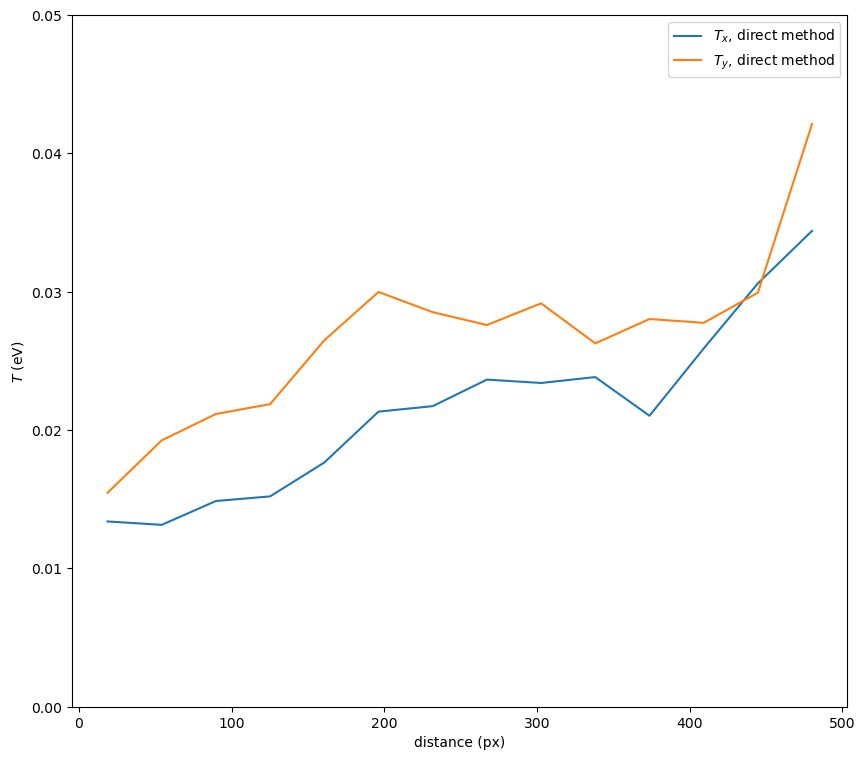

In [78]:
fig, ax = plt.subplots()
ax.plot(x_grid, arr_temper_x_dir, label = '$T_x$, direct method')
ax.plot(x_grid, arr_temper_y_dir, label = '$T_y$, direct method')
#ax.set_xlim(0, 400)
ax.set_ylim(0,0.05)
ax.set_xlabel('distance (px)')
ax.set_ylabel('$T$ (eV)')
ax.legend()